## Машинное обучение: задача классификации

Задача классификации ставится, когда необходимо разделить объекты в датасете на два или более классов. Можно сказать, что в рассмотренной нами задаче регрессии целевая переменная - числовая, а в задаче классификации - категориальная.

Обычно отдельно выделяют **бинарную** или **двоичную классификацию**, и **многоклассовую** (которая является более общим случаем бинарной). Многоклассовая классификация может быть сведена к двоичной путём построения нескольких классификаторов one-vs-all.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets
from sklearn.model_selection import train_test_split

Чтобы посмотреть, как решается задача классификации, сгенерируем случайный датасет. Для наглядности будем использовать размерность задачи 2, чтобы можно было визуализировать картину на плоскости:

In [ ]:
X,Y = sk.datasets.make_classification(
    n_samples=1000,n_features=2,random_state=13,
    n_informative=2,n_redundant=0,
    class_sep=2,n_clusters_per_class=1,flip_y=0)

X_train,X_test,Y_train,Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
plt.show()

## Классификация как регрессия

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,Y_train)
sklearn.metrics.mean_absolute_error(model.predict(X_test),Y_test)

In [ ]:
(model.predict(X_test)>0.5).astype(int)

In [ ]:
sklearn.metrics.accuracy_score((model.predict(X_test)>0.5).astype(int),Y_test)

## Logistic Regression


In [ ]:
import sklearn.linear_model
import sklearn.preprocessing

model = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_pred)}")

Можно также предсказывать вероятности принадлежности классам:

In [ ]:
model.predict_proba(X_test[:5])

Посмотрим, как выглядит разделяющая прямая:

In [ ]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
b = model.intercept_
W = model.coef_[0]
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

Рассмотрим практическую задачу - классификацияю пассажиров Титаника. Для начала загрузим датасет:

In [ ]:
import pandas as pd
df = pd.read_csv("titanic.csv")
df

Для начала нам необходимо проделать преобразование категориальных признаков в числовые, как мы рассматривали в прошлой лекции. В нашем случае, необходимо преобразовать пол, который является номинальным признаком. Поскольку значения всего два, не очень принципиально, использовать ли Label Encoding или One-Hot Encoding.

In [ ]:
df["nsex"] = df['sex'].apply(lambda x: 0 if x=="male" else 1)

Также можно заметить, что некоторые значения возраста отсутствуют. Посмотрим, сколько таких строк:

In [ ]:
df['age'].isna().sum()

У нас есть несколько вариантов, как быть с этим показателем:
* Убрать все строки, где есть отсутствующие значения. Это слишком дорогой способ, поскольку у нас значения отстуствуют в более, чем 10% строк.
* Убрать весь столбец `age` из рассмотрения. Также не очень хороший вариант
* Заполнить отсутствующие значения некоторыми другими, например, средним:

In [ ]:
df['fage'] = df['age'].fillna(df['age'].mean())
df['fagesq'] = df['fage'].apply(lambda x: x*x)/2500.0
df

Теперь, когда мы очистили данные, можем извлечь интересующие нас признаки и разбить на обучающую и тестовую выборку:

In [ ]:
features = ['pclass','nsex','fage','sibsp','parch','fagesq']
X = df[features]
Y = df['survived']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

Обучаем модель:

In [ ]:
model = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_pred)}")

Чтобы поподробнее разобраться в том, как устроена ошибка, посмотрим на так называемую **матрицу ошибок** (*confusion matrix*):

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,Y_test)
plt.show()

Для классификации имеет смысл говорить также про другие метрики:

In [ ]:
print(sk.metrics.classification_report(Y_test,Y_pred))

Посмотрим, как выглядит ROC-кривая для нашей модели и метрика AUC: 

In [ ]:
fpr, tpr, thresholds = sk.metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,7))
plt.plot(fpr,tpr)
plt.grid()
plt.plot([0,1],[0,1],c='r')

In [ ]:
sk.metrics.auc(fpr,tpr)

In [ ]:
sk.metrics.PrecisionRecallDisplay.from_estimator(model,X_test,Y_test)
#sk.metrics.RocCurveDisplay.from_estimator(model,X_test,Y_test)

Попробуем интерпретировать линейную модель, посмотрев на коэффициенты:

In [ ]:
list(zip(features,model.coef_[0]))

In [ ]:
plt.bar(features,model.coef_[0])

## Деревья решений

В отличие от линейных моделей, деревья решений хорошо работают для категориальных атрибутов. Простейший алгоритм построения дерева называется [ID3](https://ru.wikipedia.org/wiki/ID3_(%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC)).

Будем рассматривать только категориальные атрибуты нашей модели - пол (`sex`) и класс (`pclass`). Добавим для интереса ещё один категориальный атрибут: возраст:


In [ ]:
df['agecat'] = df['age'].apply(lambda x: "young" if x<18 else "old" if x>45 else "middle")

Предположим, мы хотим предсказывать вероятность выживания только на основе пола. В этом случае, средняя вероятность равна:

In [ ]:
for s in df['sex'].unique():
    print(f"Probability for sex={s} is {df[df['sex']==s]['survived'].mean()}")

Т.е. мы можем предсказывать "выжил" для всех женщин, и "не выжил" для все мужчин - и это будет давать нам некоторую точность предсказания.

Но вдруг было бы правильнее сначала смотреть не на пол, а на класс? Посмотрим, какая точность была бы у результирующей модели, если бы мы выбрали в качестве решающего атрибута пол, класс или возрастную категорию:

In [ ]:
def accuracy_by_attr(df,attr):
    p = {}
    for k in df[attr].unique():
        p[k] = int(df[df[attr]==k]['survived'].mean()>=0.5)
    return df.apply(lambda x: p[x[attr]]==x['survived'],axis=1).mean()

for a in ['pclass','sex','agecat']:
    print(f"Accuracy by {a} = {accuracy_by_attr(df,a)}")

Таким образом, выгоднее всего сначала смотреть на пол пассажира. Далее, разделяем датасет на два подмножества, и для каждого из них повторяем этот процесс. Например, вот как будет выглядеть точность для мужчин и женщин, если смотреть далее на атрибут `pclass`:

In [ ]:
for sex in ['male','female']:
    print(f'=={sex}==')
    df_1 = df[df['sex']==sex]
    for z in ['pclass','agecat']:
        print(f"{sex}, accuracy by {z} = {accuracy_by_attr(df_1,z)}")

Усовершенствованным вариантов ID3 является алгоритм [С4.5](https://ru.wikipedia.org/wiki/C4.5), разработанный тем же автором, Джоном Квинланом. В нём поддерживается отсечение ветвей, работа с числовыми атрибутами (т.е. автоматическое добавление оптимального разделения наподобие того, как мы вручную делали с возрастом), а также работа с неполной выборкой (с отсутствующими атрибутами).

Применим классификацию в виде деревья решений из SkLearn:

In [ ]:
import sklearn.tree 

model = sk.tree.DecisionTreeClassifier().fit(X_train,Y_train)
Y_pred = model.predict(X_test)
sk.metrics.accuracy_score(Y_test,Y_pred)

Как видим, точность примерно соответствует линейной модели. В зависимости от задачи, однако, мы можем получать разную точность - именно поэтому имеет право на жизнь подход Automatic ML, о котором мы говорили ранее.

Плюсом деревьев решений является их интерпретируемость. Можем попробовать построить дерево небольшой глубины, и затем его визуализировать:

In [ ]:
model = sk.tree.DecisionTreeClassifier(max_depth=3).fit(X_train,Y_train)

import graphviz
graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'

graphviz.Source(
    sk.tree.export_graphviz(model,feature_names=features,class_names=['no','yes'],
    filled=True, rounded=True, special_characters=True,impurity=False)
)

Видим, что как и в нашем случае пол является главным решающим фактором, после чего наступают более сложные решения. 

### Машина опорных векторов (SVM)

В заключение поговорим о ещё одной линейной модели - машине опорных векторов. Для этого вернёмся к исходной задаче - разделении классов точек на плоскости.

In [ ]:
X,Y = sk.datasets.make_classification(
    n_samples=1000,n_features=2,random_state=3,
    n_informative=2,n_redundant=0,
    class_sep=2,n_clusters_per_class=1,flip_y=0)

plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
plt.show()

Идея метода опорных векторов состоит в том, чтобы построить такую разделяющую прямую $w_0x_0+w_1x_1+b=0$, которая бы обеспечивала максимальный "зазор" между разделяемыми классами. Варьируя угол наклона разделяющей прямой мы добиваемся максимального зазора. При этом элементы, на которые "опираются" прямые, называются **опорными векторами**:

In [ ]:
import sklearn.svm, sklearn.inspection

model = sk.svm.SVC(kernel="linear", C=1000)
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()
# строим разделяющие прямые
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)
# обводим опорные вектора
ax.scatter(
    model.support_vectors_[:, 0], model.support_vectors_[:, 1],
    s=100, linewidth=1, facecolors="none", edgecolors="k")

plt.show()

Данный метод похож на логистическую регрессию, но использует другую функцию ошибки, позволяющую уменьшить зазор. За счет того, что при построении разделяющей прямой (или гиперплоскости, в случае большей размерности) используются близлежащие точки - опорные вектора, повышается эффективность метода для большого количества входных обучающих данных.

Для разделения линейно - неразделимых множеств SVM допускает использование нелинейных **функций ядра** (*kernel functions*). Например, если мы будет использовать метод SVM из Scikit Learn по умолчанию, то будут использованы нелинейные функции ядра: 

In [ ]:
import sklearn.svm, sklearn.inspection

model = sk.svm.SVC()
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()
# строим разделяющие прямые
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)
# обводим опорные вектора
ax.scatter(
    model.support_vectors_[:, 0], model.support_vectors_[:, 1],
    s=100, linewidth=1, facecolors="none", edgecolors="k")

plt.show()

Рассмотрим случай, когда множества точек не являются линейно разделимыми. Такой датасет мы можем сгненерировать при помощи функции `make_circles`:

In [ ]:
X,Y = sk.datasets.make_circles(n_samples=100,factor=0.5,noise=0.1)
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])
plt.show()

Применим к этому алгоритм опорных вектором с нелинейными ядерными функциями:

In [ ]:
model = sk.svm.SVC()
model.fit(X, Y)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])
ax = plt.gca()
# строим разделяющие прямые
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)

plt.show()

Посмотрим на пример, как меняется точность классификации при использовании линейных и нелинейных моделей:

In [ ]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

linmodel = sk.linear_model.LogisticRegression().fit(X_train,Y_train)
model = sk.svm.SVC().fit(X_train,Y_train)

print(f"Linear accuracy = {sk.metrics.accuracy_score(Y_test,linmodel.predict(X_test))}")
print(f"Non-lin SVM accuracy = {sk.metrics.accuracy_score(Y_test,model.predict(X_test))}")

Отметим, что мы можем добиться высокой точности модели, добавив вручную дополнительные признаки в виде квадратов к нашему датасету:

In [ ]:
X_train_aug = np.hstack([X_train,X_train*X_train])
X_test_aug = np.hstack([X_test,X_test*X_test])

linaugmodel = sk.linear_model.LogisticRegression().fit(X_train_aug,Y_train)

print(f"Augmented linear accuracy = {sk.metrics.accuracy_score(Y_test,linaugmodel.predict(X_test_aug))}")


Такого же результата можно было добиться, используя трансформер `PolynomialFeatures`:

In [ ]:
import sklearn.pipeline

pipe = sk.pipeline.Pipeline([
    ('PolyTransformer',sk.preprocessing.PolynomialFeatures()),
    ('LinearModel',sk.linear_model.LogisticRegression())
])
pipe.fit(X_train,Y_train)
print(f"Pipeline accuracy = {sk.metrics.accuracy_score(Y_test,pipe.predict(X_test))}")


### Мультиклассовая классификация

В качестве задачи мультиклассовой классификации рассмотрим задачу распознавания рукописных цифр. Для этого используем датасет [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)) - это датасет рукописных цифр, подготовленный национальным институтом стандартов США. Но содержит обучающий набор в 60000 рукописных цифр, собранный от 250 различных студентов и сотрудников института, а также тестовый набор из 10000 цифр, собранных от других сотрудников. Каждая цифра представляется матрицей 28x28 точек в 256 градациях серого.


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

X = mnist.data
Y = mnist.target
print(X.shape, Y.shape)

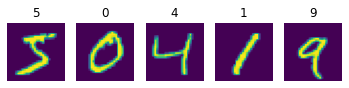

In [3]:
fig,ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(X.iloc[i].to_numpy().reshape(28,28))
    ax[i].axis('off')
    ax[i].set_title(Y[i])
plt.show()

Датасет состоит из 70000 рукописных цифр размерностью 28 на 28 пикселей, в 256 градациях яркости.

Для начала, разобьем датасет на обучаующую и тестовую выборки. Для увеличения скорости будем использовать по 10000 цифр в обучающем и тестовом датасете. Вы можете попробовать использовать весь датасет, но в этом случае приготовьтесь ждать!

In [4]:
X_train, X_test, Y_train, Y_test = \
  sk.model_selection.train_test_split(X,Y,train_size=10000, test_size=10000,shuffle=True)

Рассмотренные нами алгоритмы классификации были **бинарными**, поэтому для многоклассовой классификации можно использовать подход **один против всех**. Например, обучим классификатор для обнаружения цифры 0:

In [12]:
import sklearn.linear_model

Y0_train = Y_train=="0"
Y0_test = Y_test==0
model = sk.linear_model.LogisticRegression().fit(X_train,Y0_train)
sk.metrics.accuracy_score(Y0_test,model.predict(X_test))

0.9004

Видим здесь важную проблему - алгоритм оптимизации предупреждает, что не удалось достичь сходимости. Это может быть вызвано двумя проблемами:

* Используемый по умолчанию в `LogisticRegression` оптимизатор - это не совсем градиентный спуск, а алгоритм `lbfgs`, который хорошо работает на сравнительно небольших датасетах. Можно попробовать задать другой оптимизатор параметром `solver=...`.
* Cогласно негласному соглашению, входные числовые признаки должны находиться в районе диапазона 0..1 - исходя из этого реализованы все алгоритмы внутри библиотек. Это особенно важно, поскольку во многих случаях признаки имеют различный диапазон (например, рост человека меняется от 30 до 250 см., в то время как возраст - от 0 до 120), и для более *честного* обучения имеет смысл приводить их к единому диапазону. Мы раньше не занимались приведением признаков к диапазону 0..1, поскольку мы не сталкивались с моделями большой размерности. Здесь же мы имеем 768 входов, и значения в интервале 0..255, которые сильно выходят за рамки общепринятого.

Для борьбы с проблемой нормируем все значения в датасете:

In [ ]:
model = sk.linear_model.LogisticRegression(solver='newton-cg').fit(X_train/255.0,Y0_train)
sk.metrics.accuracy_score(Y0_test,model.predict(X_test/255.0))

Получаем точность около 90% на классификации "ноль-не ноль". Для многоклассовой классификации нам необходимо построить 10 таких моделей, по одной на каждую цифру. Sklearn содержит специальный класс, который позволяет превратить любой двоичный классификатор в мультиклассовый с помощью подхода **One vs. All**:

In [13]:
import sklearn.multiclass

model = sk.multiclass.OneVsRestClassifier(
    sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1))
model.fit(X_train/255.0, Y_train)
sk.metrics.accuracy_score(Y_test,model.predict(X_test/255.0))

0.9006

Можем посмотреть на матрицу ошибок:

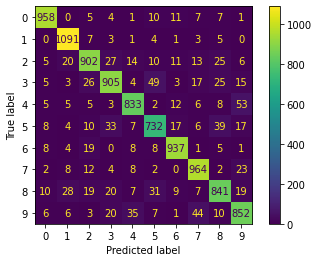

In [15]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_test/255.0,Y_test)
plt.show()

`OneVsRestClassifier` может превратить любой бинарный классификатор в мультиклассовый. Однако многие классификаторы в SkLearn, включая логистическую регрессию, поддерживают мультиклассовый режим. Поэтому мы можем подавать мультиклассовые данные напрямую на вход `LogisticRegression`:

In [14]:
model = sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1)
model.fit(X_train/255.0, Y_train)
sk.metrics.accuracy_score(Y_test,model.predict(X_test/255.0))

0.9015

Интересно посмотреть на коэффициенты (веса) получившейся модели. В мультиклассовом случае, размерность вектора коэффициентов `model.coef_` будет $10\times784$ - это соответствует 10 классам, по $768=28\times28$ коэффициентов в каждом. Соответственно, можем попробовать визуализировать это как изображение: 

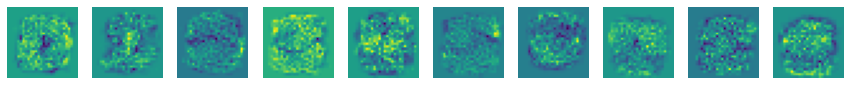

In [16]:
fig,ax = plt.subplots(1,10,figsize=(15,6))
for i in range(10):
    ax[i].imshow(model.coef_[i].reshape(28,28))
    ax[i].axis('off')
plt.show()

Из картинки становится примерно понятно, как работает такой классификатор - он умножает шаблон с коэффициентами на изображение, и выход получается тем больше, чем лучше шаблон совпадает с картинкой. Положительные коэффициенты в шаблоне соответствуют тем пикселям, которые должны присутствовать для данной цифры, а отрицательные - те, которые для такой цифры не характерны.

### Кросс-валидация

Для проверки точности модели мы обычно использовали подход с разбиением выборки на обучающую и тестовую. Однако в этом случае часть выборки "теряется" и не используется для обучения; кроме того - есть вероятность, что конкретное разбиение на обучающую и тестовую выборку оказалось каким-то "неудачным".

Для преодоления этих сложностей может использоваться подход, называемый **кросс-валидацией** (*K-Fold Cross-Validation*). В этом случае датасет разделяется на $k$ частей, и проводится $k$ экспериментов, в которых одна из частей используется для валидации, а остальные - для обучения. Полученные результаты (точность) затем усредняются.

Scikit Learn позволяет провести обучение с кросс-валидацией:

In [17]:
model = sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1)
scores = sk.model_selection.cross_val_score(model,X/255.0,Y,cv=5) 
scores

array([0.92192857, 0.92128571, 0.91521429, 0.91828571, 0.92978571])

In [18]:
scores.mean(), scores.std()

(0.9212999999999999, 0.004868767601681531)

В методе `cross_val_score` можно задавать различные метрики для оценки, а также различные стратегии разбиения датасета (с помощью параметра `cv`).

Существует также метод `cross_val_predict`, возвращающий предсказания можели для каждого из элементов входного датасета в то время, когда он был частью тестовой выборки.

Если же нам нужно вернуть сами обученные модели, полученные в процессе кросс-валидации, то можно использовать метод `cross_validate`. Подробнее об особенностях использования этого метода можно почитать [в документации](https://scikit-learn.org/stable/modules/cross_validation.html).